In [ ]:
# dataloader
import os
from lib.env import DATA_PATH
import json
import pandas as pd
from lib.utils import *
import matplotlib.pyplot as plt
import plotly.express as px
from torch.utils.data import DataLoader,TensorDataset,ConcatDataset
import torch
from sklearn.metrics import ConfusionMatrixDisplay,classification_report

FS = 50
WINDOWSIZE = 100 * FS

In [3]:
from sage.models import ResNetv2,ResBlockv2
from tqdm import tqdm
from sage.utils import evaluate_sigmoid

hyperparameters = {
    'block':ResBlockv2,
    'widthi':[4],
    'depthi':[2],
    'n_output_neurons':1,
    'norm':'layer'
}

# traindataset = ConcatDataset([
#     get_dataset_for_project("asfiqur_phase1",windowsize=WINDOWSIZE),
#     get_dataset_for_project("asfiqur_phase2",windowsize=WINDOWSIZE), # TODO error with tonmoy_phase1 write regions
#     get_dataset_for_project("tonmoy_phase2",windowsize=WINDOWSIZE),
#     ])

traindataset = get_dataset_for_project("asfiqur_phase1",windowsize=WINDOWSIZE)
devdataset = get_dataset_for_project("alsaad_phase1",windowsize=WINDOWSIZE,balance=True)
testdataset = get_dataset_for_project("alsaad_phase2",windowsize=WINDOWSIZE,balance=True)

trainloader = DataLoader(traindataset,batch_size=128,shuffle=True)
devloader = DataLoader(devdataset,batch_size=128,shuffle=True)
testloader = DataLoader(testdataset,batch_size=128,shuffle=True)

In [6]:
model = ResNetv2(**hyperparameters)
model.load_state_dict(torch.load(f'custom.pt',weights_only=False))
optimizer = torch.optim.AdamW(model.parameters(),lr=3e-4)
criterion = torch.nn.BCEWithLogitsLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=50)

305 params


              precision    recall  f1-score   support

         0.0       0.94      0.93      0.94      5648
         1.0       0.94      0.94      0.94      5648

    accuracy                           0.94     11296
   macro avg       0.94      0.94      0.94     11296
weighted avg       0.94      0.94      0.94     11296

              precision    recall  f1-score   support

         0.0       0.88      0.94      0.91      3884
         1.0       0.93      0.87      0.90      3884

    accuracy                           0.90      7768
   macro avg       0.90      0.90      0.90      7768
weighted avg       0.90      0.90      0.90      7768

              precision    recall  f1-score   support

         0.0       0.80      0.94      0.86      1428
         1.0       0.92      0.77      0.84      1428

    accuracy                           0.85      2856
   macro avg       0.86      0.85      0.85      2856
weighted avg       0.86      0.85      0.85      2856



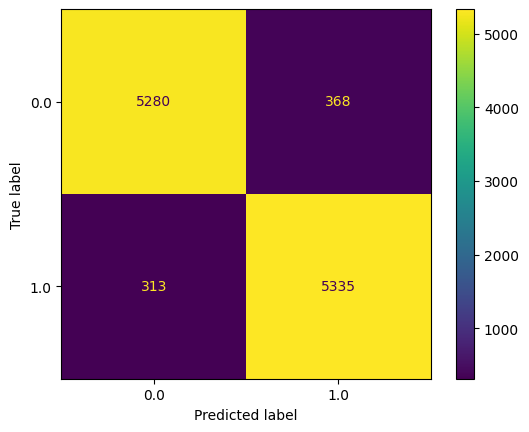

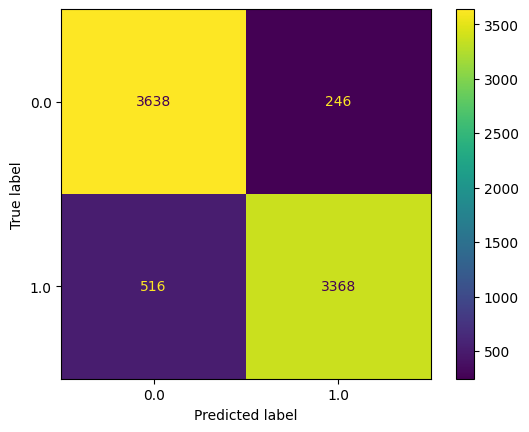

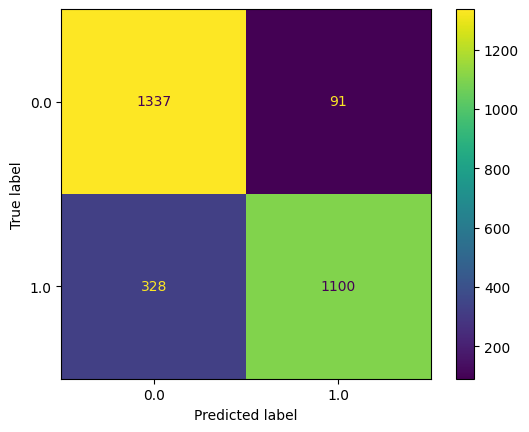

In [7]:
loss,y_true,y_pred = evaluate_sigmoid(trainloader,model,criterion)
ConfusionMatrixDisplay.from_predictions(y_true,y_pred)
print(classification_report(y_true,y_pred))
loss,y_true,y_pred = evaluate_sigmoid(devloader,model,criterion)
ConfusionMatrixDisplay.from_predictions(y_true,y_pred)
print(classification_report(y_true,y_pred))
loss,y_true,y_pred = evaluate_sigmoid(testloader,model,criterion)
ConfusionMatrixDisplay.from_predictions(y_true,y_pred)
print(classification_report(y_true,y_pred))

In [4]:
project = 'alsaad_phase1'
windowsize = WINDOWSIZE
stride = 100
labels_path = f'{DATA_PATH}/1_labeled/{project}/labels.json'
with open(labels_path, 'r') as f:
    labels = json.load(f)
regions = os.listdir(f'{DATA_PATH}/2_regions/{project}')

X_train = []
y_train = []

for region in regions[:1]:
    df = pd.read_csv(f'{DATA_PATH}/2_regions/{project}/{region}')
    df.timestamp = df.timestamp.astype('datetime64[ns]')
    region_labels = [(datetime.datetime.strptime(label['start'], '%Y-%m-%d %H:%M:%S.%f'),datetime.datetime.strptime(label['end'], '%Y-%m-%d %H:%M:%S.%f')) for label in labels]
    region_labels = [label for label in region_labels if ((label[0] > df.timestamp.min()) & (label[1] < df.timestamp.max()))]
    df['y_true'] = 0
    for label in region_labels:
        df.loc[((df.timestamp > label[0]) & (df.timestamp < label[1])),'y_true'] = 1
    # df_resampled = df.set_index('timestamp').resample('20ms').mean().reset_index()
    df_resampled = df.copy()
    X = torch.from_numpy(df_resampled[['x','y','z']].values).float()
    y = torch.from_numpy(df_resampled['y_true'].values).float()
    for i in range(0,len(X) - windowsize,stride):
        X_train.append(X[i:i+windowsize])
        y_train.append(y[i + (windowsize // 2)])
X_train = torch.stack(X_train).transpose(1,2)
y_train = torch.tensor(y_train).reshape(-1,1).float()

In [7]:
y_pred = model(X_train).sigmoid()

In [ ]:
y_pred.shape

In [ ]:
df

In [ ]:
y_train.shape

In [ ]:
plt.plot(torch.repeat_interleave(y_pred,100).detach())
plt.plot(torch.repeat_interleave(y_train,100).detach())

In [ ]:

idx_0 = torch.where(y_train == 0)[0]
idx_0 = idx_0[torch.randperm(len(idx_0))[:torch.bincount(y_train.flatten().long())[1]]]
idx_1 = torch.where(y_train == 1)[0]
idx = torch.cat([idx_0,idx_1])
X_train,y_train = X_train[idx],y_train[idx]

# return TensorDataset(X_train,y_train)

In [ ]:
devdataset = get_dataset_for_project_eval("alsaad_phase1",windowsize=WINDOWSIZE)
testdataset = get_dataset_for_project_eval("alsaad_phase2",windowsize=WINDOWSIZE)

trainloader = DataLoader(traindataset,batch_size=128,shuffle=True)
devloader = DataLoader(devdataset,batch_size=128,shuffle=True)
testloader = DataLoader(testdataset,batch_size=128,shuffle=True)